#### Imports

In [1]:
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_columns',None)

In [2]:
data = pd.read_csv('/Users/dylanhayashi/Desktop/MSDS 422 - Practical Machine Learning/Module 4/data-2.csv')

#### Target Variable: Bankrupt

In [3]:
# Describe
y_train = data.loc[:,'Bankrupt?']
round(y_train.describe(),3)

count    6819.000
mean        0.032
std         0.177
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: Bankrupt?, dtype: float64

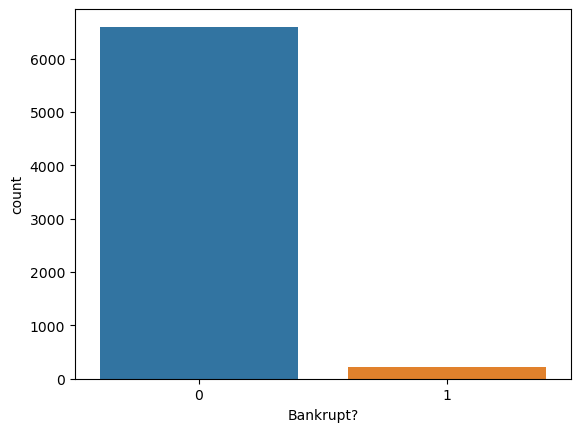

In [4]:
#S4 EDA Frequency Plot of Target variable
sns_plot =sns.countplot(x = y_train)
plt.show()

In [5]:
print(f'Bankrupt has a skew of {round(y_train.skew(),3)}')

Bankrupt has a skew of 5.295


#### Independent Variables

In [6]:
# Describe
variable_descriptions = data.describe(percentiles=[.05, .25, .75, .95],include='all')
variable_descriptions_two = data.isna().sum().to_frame(name = 'missing').T
summary = pd.concat([variable_descriptions, variable_descriptions_two])
print('Observations:\nThere are no missing values in this dataset.\nAll of the variables are scaled.')
display(round(summary,3))

Observations:
There are no missing values in this dataset.
All of the variables are scaled.


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6.819000e+03,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6.819000e+03,6819.000,6819.000,6.819000e+03,6.819000e+03,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000,6.819000e+03,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6.819000e+03,6819.000,6819.000,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6.819000e+03,6.819000e+03,6819.000,6.819000e+03,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6.819000e+03,6819.000,6819.000,6819.000,6819.000,6819.000,6819.000,6819.0,6819.000
mean,0.032,0.505,0.559,0.554,0.608,0.608,0.999,0.797,0.809,0.304,0.781,1.995347e+09,1.950427e+09,0.467,1.644801e+07,0.115,0.191,0.191,0.191,0.229,0.323,1.328641e+06,0.109,0.184,0.022,0.848,0.689,0.689,0.218,5.508097e+09,1.566212e+06,0.264,0.380,4.032850e+05,8.376595e+06,0.631,4.416337e+06,0.113,0.887,0.009,0.375,0.006,0.109,0.183,0.402,0.142,1.278971e+07,9.826221e+06

#### Correlation

In [7]:
# Calculate and present variables by absolute correlation with Bankrupt?
corr_table = pd.DataFrame(columns = ['variable','corr'])

for variable in data.columns:
    observations = data.loc[:,variable]
    corr = abs(round(observations.corr(y_train),3))
    var_row = pd.DataFrame({'variable' : [variable], 'corr':[corr]})
    corr_table = corr_table.append(var_row)
    corr_table = corr_table.sort_values(['corr'], ascending = False)
    
print('I will be using the 10 most highly correlated variables.')
display(corr_table[1:11])

correlated_variables = data.loc[:,corr_table['variable'][0:11]]

I will be using the 10 most highly correlated variables.


,variable,corr
0,Net Income to Total Assets,0.315
0,ROA(A) before interest and % after tax,0.283
0,ROA(B) before interest and depreciation after...,0.273
0,ROA(C) before interest and depreciation befor...,0.261
0,Net worth/Assets,0.250
0,Debt ratio %,0.250
0,Persistent EPS in the Last Four Seasons,0.220
0,Retained Earnings to Total Assets,0.218
0,Net profit before tax/Paid-in capital,0.208
0,Per Share Net profit before tax (Yuan ¥),0.201


#### Distributions of Independent Variables

The variables all have distributions that approximate normal with some skew.


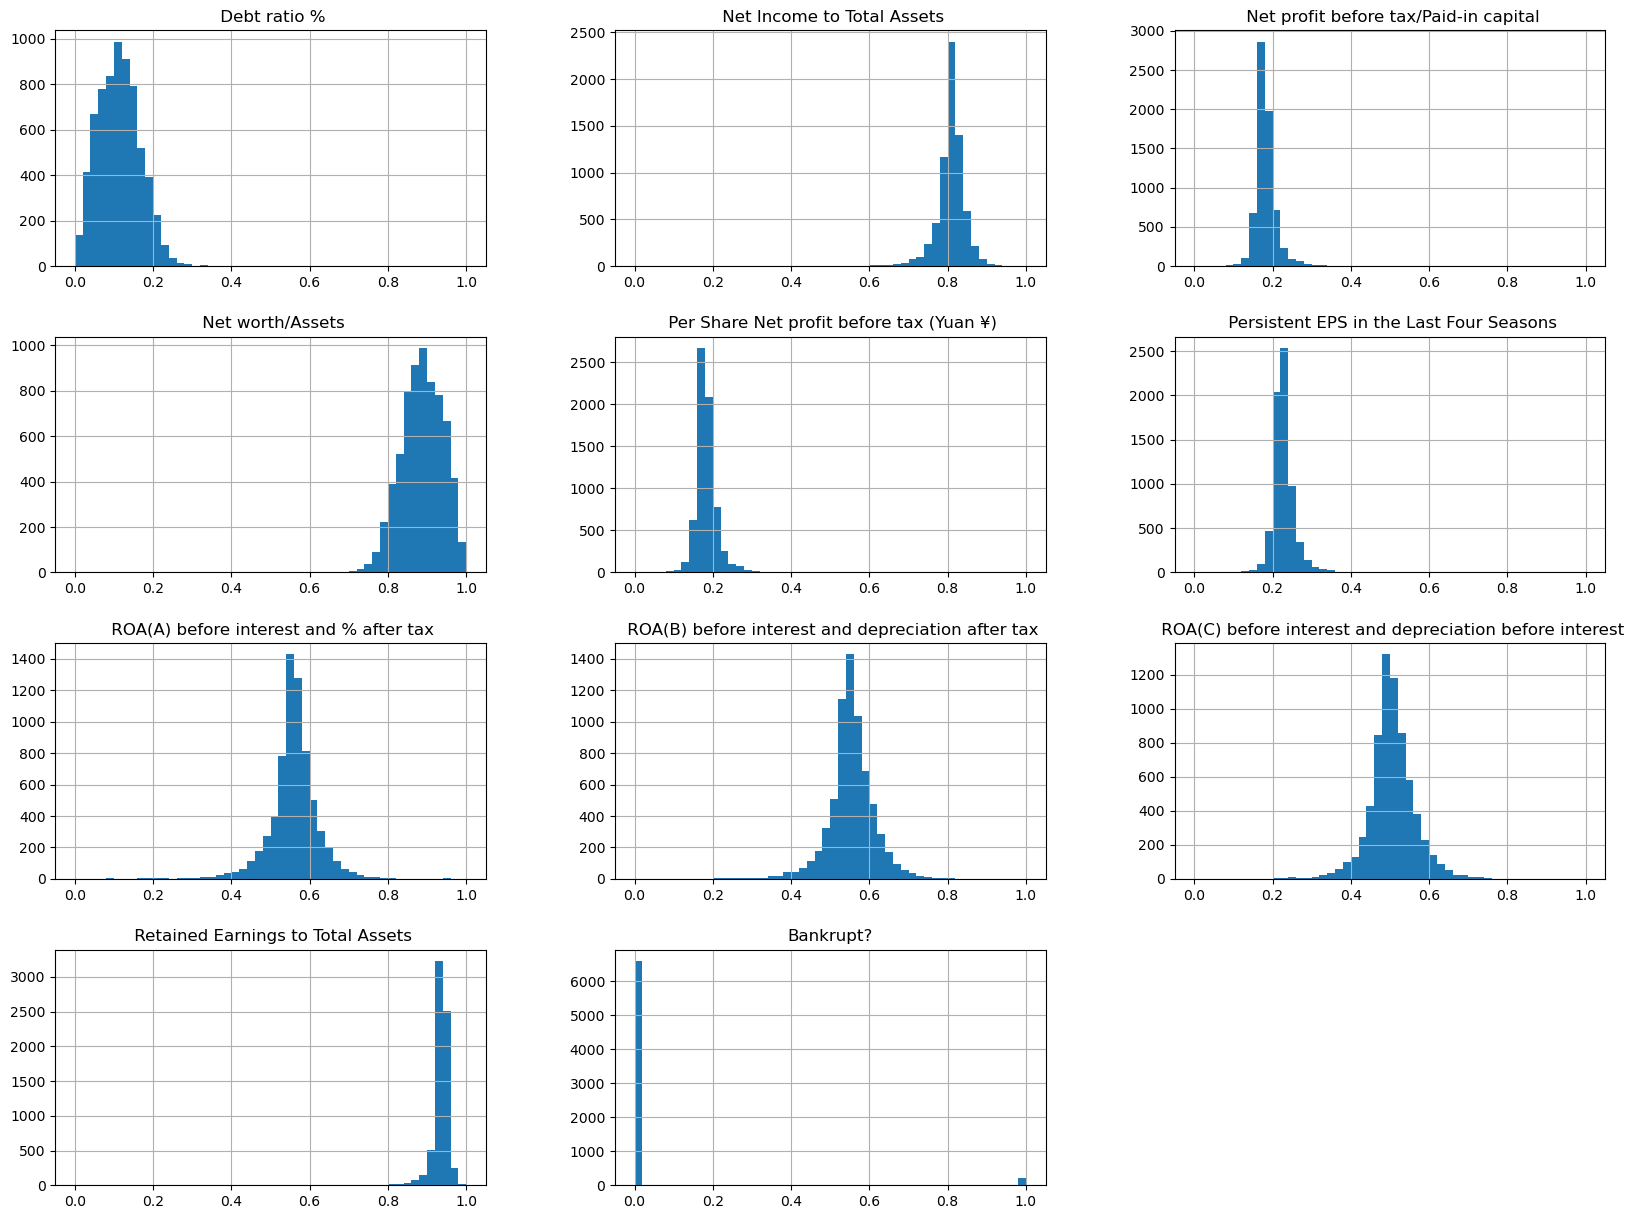

In [8]:
correlated_variables.hist(bins=50, figsize=(20,15))
print('The variables all have distributions that approximate normal with some skew.')
plt.show()

#### Create Final Training X and Y Sets

In [9]:
x_train = pd.DataFrame(correlated_variables.loc[:,correlated_variables.columns[1:]])
y_train = pd.Series(correlated_variables.loc[:,'Bankrupt?'])

print('X Train:')
display(x_train.head())

print('\nY Train:')
display(y_train)

X Train:


,Net Income to Total Assets,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,ROA(C) before interest and depreciation before interest,Net worth/Assets,Debt ratio %,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets,Net profit before tax/Paid-in capital,Per Share Net profit before tax (Yuan ¥)
0,0.716845,0.424389,0.405750,0.370594,0.792424,0.207576,0.169141,0.903225,0.137757,0.138736
1,0.795297,0.538214,0.516730,0.464291,0.828824,0.171176,0.208944,0.931065,0.168962,0.169918
2,0.774670,0.499019,0.472295,0.426071,0.792484,0.207516,0.180581,0.909903,0.148036,0.142803
3,0.739555,0.451265,0.457733,0.399844,0.848535,0.151465,0.193722,0.906902,0.147561,0.148603
4,0.795016,0.538432,0.522298,0.465022,0.893491,0.106509,0.212537,0.913850,0.167461,0.168412



Y Train:


0       1
1       1
2       1
3       1
4       1
       ..
6814    0
6815    0
6816    0
6817    0
6818    0
Name: Bankrupt?, Length: 6819, dtype: int64

### Logistic Regression

Hyperparameters:


{'C': [0.001, 0.01, 0.1, 1, 5, 10]}


Cross-Validation Results:
Test set score: 0.93
Best parameters: {'C': 5}
Best cross-validation score: 0.92
Best estimator:
LogisticRegression(C=5)

Confusion Matrix


array([[6574,  192],
       [  25,   28]])


Results:
Precision Score: 0.528
Recall Score: 0.127
FPR: 0.00379
TPR: 0.12727
F-Score: 0.205

ROC Curve:


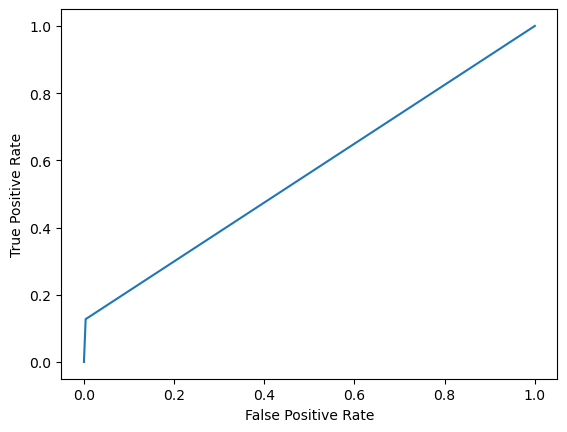

Precision Recall Curve:


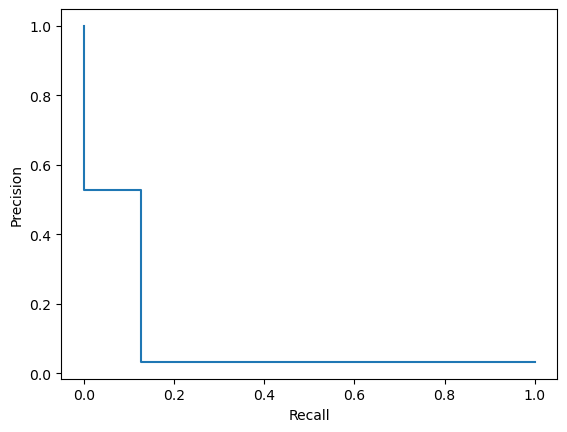

In [10]:
# Set Hyper Parameters
lr_param = {'C': [0.001, 0.01, 0.1, 1, 5, 10]}
print('Hyperparameters:')
display(lr_param)

# Create Model
lr = GridSearchCV(LogisticRegression(), lr_param, cv=10, scoring="roc_auc", return_train_score=True)
lr.fit(x_train, y_train)

# Scores
print('\nCross-Validation Results:')
print("Test set score: {:.2f}".format(lr.score(x_train, y_train)))
print("Best parameters: {}".format(lr.best_params_))
print("Best cross-validation score: {:.2f}".format(lr.best_score_))
print("Best estimator:\n{}".format(lr.best_estimator_))

# Predict
y_pred = lr.predict(x_train)

# Confusion Matrix
matrix = confusion_matrix(y_pred, y_train)
print('\nConfusion Matrix')
display(matrix)

# Precision / Recall
print('\nResults:')
print(f'Precision Score: {round(precision_score(y_train, y_pred), 3)}')
print(f'Recall Score: {round(recall_score(y_train, y_pred), 3)}')
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
print(f'FPR: {round(fpr[1],5)}')
print(f'TPR: {round(tpr[1],5)}')
print(f'F-Score: {round(f1_score(y_train, y_pred),3)}\n')

# ROC Curve
curve = RocCurveDisplay(fpr=fpr, tpr=tpr)
curve.plot()
print('ROC Curve:')
plt.show()

# Precision Recall Curve
print('Precision Recall Curve:')
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
curve = PrecisionRecallDisplay(precision=precision, recall=recall)

curve.plot()
plt.show()

### Naive Bayes Classifier

In [ ]:
# Set Hyperparameters
nb_param = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}
print('Hyperparameters')
display(nb_param)

#nb
nb =GridSearchCV(BernoulliNB(binarize=0.5, class_prior = [0.5, 0.5], fit_prior=False), nb_param, cv=10, 
                    scoring="roc_auc", return_train_score=True)                
nb.fit(x_train, y_train)

# Scores

Hyperparameters


{'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}


Cross-Validation Results:
Test set score: 0.84
Best parameters: {'alpha': 0.001}
Best cross-validation score: 0.84
Best estimator:
BernoulliNB(alpha=0.001, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Confusion Matrix


array([[5786,   82],
       [ 813,  138]])


Results:
Precision Score: 0.145
Recall Score: 0.627
FPR: 0.1232
TPR: 0.62727
F-Score: 0.236

ROC Curve:


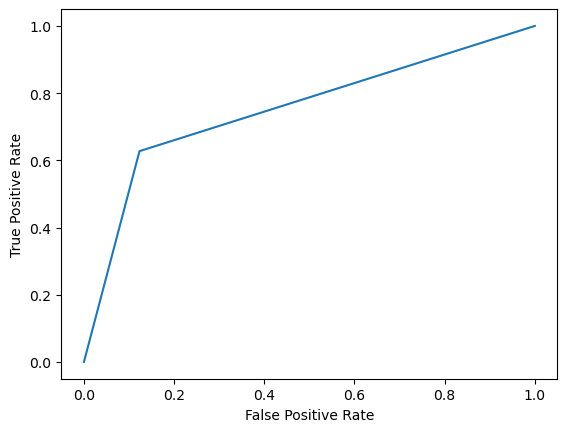

Precision Recall Curve:


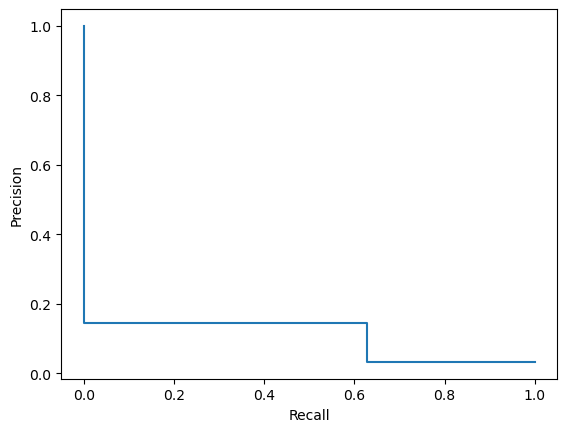

In [11]:
# Set Hyperparameters
nb_param = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}
print('Hyperparameters')
display(nb_param)

#nb
nb =GridSearchCV(BernoulliNB(binarize=0.5, class_prior = [0.5, 0.5], fit_prior=False), nb_param, cv=10, 
                    scoring="roc_auc", return_train_score=True)                
nb.fit(x_train, y_train)

# Scores
print('\nCross-Validation Results:')
print("Test set score: {:.2f}".format(nb.score(x_train, y_train)))
print("Best parameters: {}".format(nb.best_params_))
print("Best cross-validation score: {:.2f}".format(nb.best_score_))
print("Best estimator:\n{}".format(nb.best_estimator_))

# Predict
y_pred = nb.predict(x_train)

# Confusion Matrix
matrix = confusion_matrix(y_pred, y_train)
print('\nConfusion Matrix')
display(matrix)

# Precision / Recall
print('\nResults:')
print(f'Precision Score: {round(precision_score(y_train, y_pred), 3)}')
print(f'Recall Score: {round(recall_score(y_train, y_pred), 3)}')
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
print(f'FPR: {round(fpr[1],5)}')
print(f'TPR: {round(tpr[1],5)}')
print(f'F-Score: {round(f1_score(y_train, y_pred),3)}\n')

# ROC Curve
curve = RocCurveDisplay(fpr=fpr, tpr=tpr)
curve.plot()
print('ROC Curve:')
plt.show()

# Precision Recall Curve
print('Precision Recall Curve:')
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
curve = PrecisionRecallDisplay(precision=precision, recall=recall)

curve.plot()
plt.show()

### Support Vector Machine

Hyperparameters:


{'C': [0.001, 0.01, 0.1, 1, 5, 10]}


Cross-Validation Results:
Test set score: -0.02
Best parameters: {'C': 10}
Best cross-validation score: -0.17
Best estimator:
SVR(C=10)

Predictions: [0.14063785 0.09903461 0.09496739 ... 0.09203842 0.09681724 0.09529971]

ROC Curve:


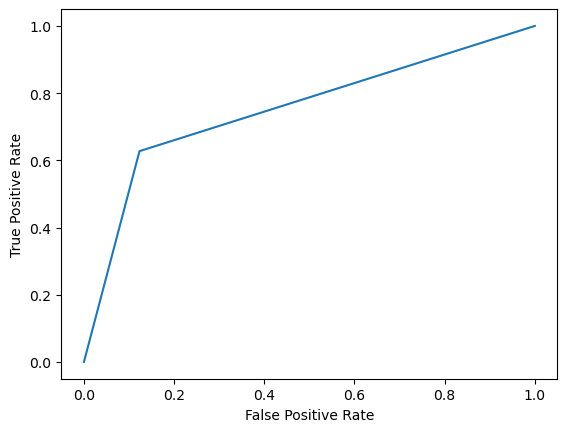


Precision Recall Curve:


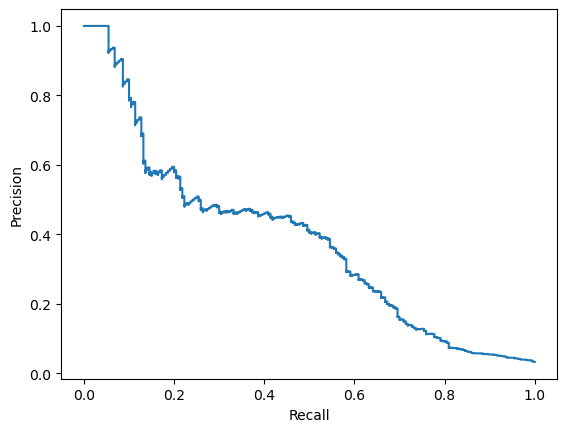

In [12]:
# Hyperparameters
svr_param = {'C': [0.001, 0.01, 0.1, 1, 5, 10]}
print('Hyperparameters:')
display(svr_param)

# svm
svr = GridSearchCV(svm.SVR(),svr_param)   
svr.fit(x_train, y_train)

# Scores
print('\nCross-Validation Results:')
print("Test set score: {:.2f}".format(svr.score(x_train, y_train)))
print("Best parameters: {}".format(svr.best_params_))
print("Best cross-validation score: {:.2f}".format(svr.best_score_))
print("Best estimator:\n{}".format(svr.best_estimator_))

# Predict
y_pred = svr.predict(x_train)
print(f'\nPredictions: {y_pred}')

# ROC Curve
curve = RocCurveDisplay(fpr=fpr, tpr=tpr)
curve.plot()
print('\nROC Curve:')
plt.show()

# Precision Recall Curve
print('\nPrecision Recall Curve:')
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
curve = PrecisionRecallDisplay(precision=precision, recall=recall)

curve.plot()
plt.show()